In [1]:
# 1. Install all system dependencies (with -y to auto-confirm)
!apt-get update
!apt-get install -y xvfb x11-xserver-utils
!apt-get install -y \
    libx11-6 \
    libxau6 \
    libxdmcp6 \
    libxcb1 \
    libxext6 \
    libx11-xcb1 \
    libvulkan1 \
    vulkan-utils \
    libvulkan-dev \
    mesa-vulkan-drivers

# 2. Install Python packages
!pip install --upgrade mani_skill tyro pyvirtualdisplay

# 3. Verify Xvfb is installed
!which Xvfb

# 4. Setup virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1024, 768))
virtual_display.start()

# Other added
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease          
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                    
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease


Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-xserver-utils is already the newest version (7.7+9build1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package vulkan-utils
/usr/bin/Xvfb
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyte

# CPU Sims

In [4]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import time
env = gym.make("PegInsertionSide-v1")
obs, _ = env.reset(seed=0)
env.unwrapped.print_sim_details() # print verbose details about the configuration
done = False
start_time = time.time()
while not done:
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
N = info["elapsed_steps"].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PegInsertionSide-v1, 1 parallel environments, sim_backend=cpu
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128), RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (1, 43), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 100 / 0.8820006847381592 = 113.37859678610924


In [5]:
from mani_skill.utils.wrappers import CPUGymWrapper
env = gym.make("PegInsertionSide-v1")
env = CPUGymWrapper(env)
obs, _ = env.reset() # obs is numpy and unbatched
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (43,)


In [10]:
import matplotlib.pyplot as plt
# env = gym.make("PegInsertionSide-v1", render_mode="rgb_array")
env = gym.make("PegInsertionSide-v1", render_mode="human")
env.reset()
env.render()

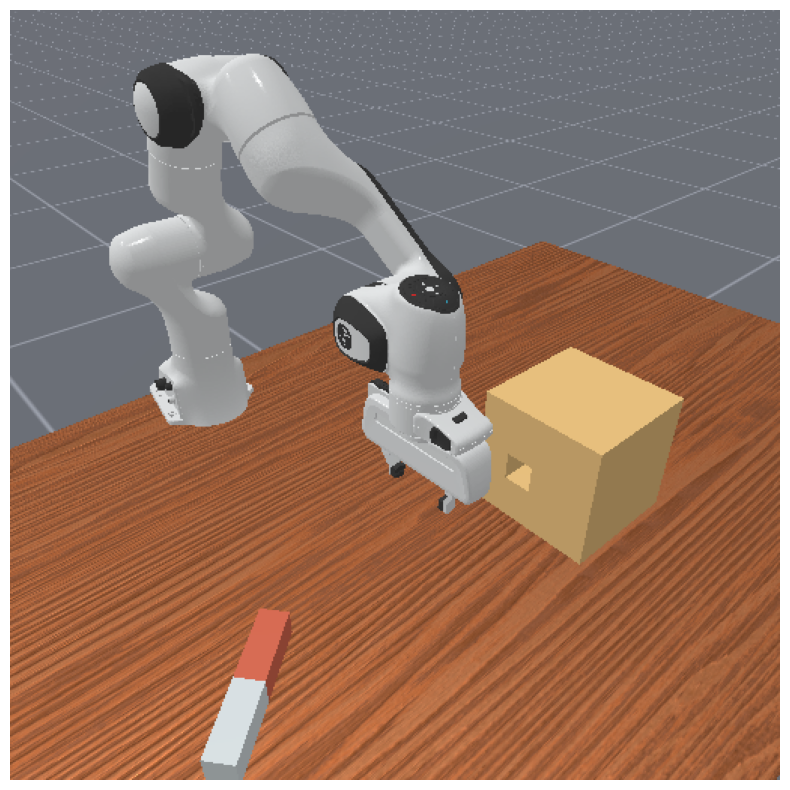

In [12]:
# Make sure virtual display is running
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# For notebook rendering
env = gym.make("PegInsertionSide-v1", render_mode="rgb_array")
obs, _ = env.reset()

# Get and display the render
img = env.render()
img = img.squeeze(0)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

# GPU Sims

In [2]:
### Make sure to restart the notebook if you already ran a CPU sim!! ###
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
import matplotlib.pyplot as plt
num_envs = 4096 # you can go up to 4096 on better GPUs
env = gym.make("PickCube-v1", num_envs=num_envs,render_mode="rgb_array")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 4096 parallel environments, sim_backend=gpu
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=rgb_array, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (4096, 42), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 204800 / 4.144533634185791 = 49414.486182649525


In [5]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows which make the default lighting cast shadows
env = gym.make("PickCube-v1", num_envs=4, render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(
    env
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2025-01-10 03:55:48,567 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/100 [00:00<?, ?it/s]